# Electric Bus Analysis

Andrew Whitman - January 5th, 2023

## Context

This data set contains information on the number of electric busses committed by each school district in the United States.  It was created by the World Resources Institute and was last updated in June 2022.  

## Content

The dataset we will primarily be working with contains the following columns.  ESB refers to Electric School Buses and LEA refers to Local Education Agency:

- Has Committed ESBs: "yes" or "no"
- State: Object
- LEA Type Number: Integer
- LEA Type: Category
- Locale Type Number: Integer
- Locale Type: Category
- Latitude: Float
- Longitude: Float
- Number of Students: Integer
- Number of Schools: Integer
- Percentage of Title 1 Schools: Float

The other data sets that we will use include: summary of ESB statistics, count of ESBs per district, 2020 election political results


## Inspiration

As a three season coach I spend more time on a bus than most people.  I did a rough calculation and came up with approximately 50 hours a year based on the number of XC and track meets I attend.  When I found this dataset, I was very excited to discover what types of schools are using electric buses.  I would love for the school district I currently work for to join in the ranks.  


## Citation
Lazer, L. and L. Freehafer. August 2022. “A Dataset of Electric School Bus Adoption in the United States.” Washington, DC: World Resources Institute.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import geoplot as gplt
from shapely.geometry import Point
from matplotlib import style
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-v0_8-colorblind')

In [2]:
# Read summary data to dataframe 

summary = pd.read_excel('Desktop/Datasets/Electric School Bus Dataset/ESB_adoption_dataset_v3_update_august_2022.xlsx',
                      sheet_name=1)
summary

,Value,June 2022 (current),March 2022,December 2021,June 2021
0,Total number of committed ESBs,12720,12275,1828.000000,1164.0
1,"Number of ESBs in ""awarded"" phase",11616,11375,NaN,NaN
2,"Number of ESBs in ""ordered"" phase",337,300,NaN,NaN
3,"Number of ESBs in ""delivered"" phase",465,313,NaN,NaN
4,"Number of ESBs in ""operating"" phase",302,285,NaN,NaN
5,Phase not applicable*,NaN,2,NaN,NaN
6,Total number of districts with committed ESBs,455,415,354.000000,258.0
7,Number of school districts or entities wi...,243,201,NaN,NaN
8,Total number of states with committed ESBs,38,38,36.000000,33.0
9,"Average time taken for ESB to move from ""Award...",15 months,16 months,NaN,NaN


### Summary

This dataframe contains a summary of the data on ESBs in the US.  As of June 2022, there are 12720 committed ESBs.  A committed ESB is an ESB that is one of the following stages: "awarded", "ordered", "delivered", "operating".  10,000 of the committed ESBs are from a contract between Midwest Transit Equipment and SEA.  These ESBs are not committed to any specific location.  We will leave them out of our analysis as we are going to focus on number of ESBs per state.

In [3]:
# Read num_ESB file to dateframe.  This file contains the number of ESBs committed in each district

num_ESB = pd.read_excel('Desktop/Datasets/Electric School Bus Dataset/ESB_adoption_dataset_v3_update_august_2022.xlsx',
                      sheet_name=3, usecols=[0,3])
num_ESB.columns = ['Bus_ID', 'LEA_ID']
num_ESB.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12720 entries, 0 to 12719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Bus_ID  12720 non-null  object
 1   LEA_ID  12720 non-null  object
dtypes: object(2)
memory usage: 198.9+ KB


In [4]:
# Get total number of buses per school district

num_ESB = num_ESB.groupby('LEA_ID').count()
num_ESB.head()

,Bus_ID
LEA_ID,
80916,1
89169,1
101560,2
200050,1
209228,1


In [5]:
# Read district file to dateframe

bus_data = pd.read_excel('Desktop/Datasets/Electric School Bus Dataset/ESB_adoption_dataset_v3_update_august_2022.xlsx',
                      sheet_name=2, usecols=[0,1,2,3,11,12,15,16,19,20,54,55,56])
bus_data.head()

,0a. Has committed ESBs?,1a. State,1b. LEA or Entity Name,1c. LEA ID,1k. LEA type (number),1l. LEA type (name),1o. Locale broad category (number),1p. Locale broad category (name),1s. Latitude,1t. Longitude,4b. Number of students in district,4c. Number of schools in district,4d. Percentage of schools in district that are Title I schoolwide eligible
0,no,ALABAMA,Acceleration Day and Evening Academy,100197,7.0,Independent charter district,1.0,Urban,30.668018,-88.119730,331.0,1.0,1.0
1,no,ALABAMA,Al Inst Deaf And Blind,100009,5.0,State agency,3.0,Town,33.431960,-86.098534,NaN,5.0,0.0
2,no,ALABAMA,Al Sch Of Math And Science,100010,5.0,State agency,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,no,ALABAMA,Alabama Aerospace and Aviation,100213,7.0,Independent charter district,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,no,ALABAMA,Alabama School of Cyber Technology and Enginee...,100212,5.0,State agency,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [6]:
# Merge bus_data with num_ESBs

bus_data = bus_data.merge(num_ESB, left_on='1c. LEA ID', right_on='LEA_ID', how='inner')
bus_data.head()

,0a. Has committed ESBs?,1a. State,1b. LEA or Entity Name,1c. LEA ID,1k. LEA type (number),1l. LEA type (name),1o. Locale broad category (number),1p. Locale broad category (name),1s. Latitude,1t. Longitude,4b. Number of students in district,4c. Number of schools in district,4d. Percentage of schools in district that are Title I schoolwide eligible,Bus_ID
0,yes,ALABAMA,Fort Payne City,101560,1.0,Regular public school district that is not a c...,3.0,Town,34.486206,-85.673755,3482.0,5.0,1.000000,2
1,yes,ALASKA,Alaska Gateway School District,200050,1.0,Regular public school district that is not a c...,4.0,Rural,63.333206,-142.958861,407.0,8.0,1.000000,1
2,yes,ARIZONA,Cartwright Elementary District (4282),401680,1.0,Regular public school district that is not a c...,1.0,Urban,33.496909,-112.170418,15177.0,23.0,0.952381,1
3,yes,ARIZONA,Phoenix Union High School District (4286),406330,1.0,Regular public school district that is not a c...,1.0,Urban,33.502319,-112.074283,27037.0,19.0,0.894737,4
4,yes,ARIZONA,Theodore Roosevelt School,5900132,1.0,Regular public school district that is not a c...,4.0,Rural,33.790127,-109.987971,100.0,1.0,1.000000,1


In [7]:
# Check null values

bus_data.isna().sum()

0a. Has committed ESBs?                                                         0
1a. State                                                                       0
1b. LEA or Entity Name                                                          0
1c. LEA ID                                                                      0
1k. LEA type (number)                                                          28
1l. LEA type (name)                                                             0
1o. Locale broad category (number)                                             21
1p. Locale broad category (name)                                               21
1s. Latitude                                                                    5
1t. Longitude                                                                   5
4b. Number of students in district                                             32
4c. Number of schools in district                                              28
4d. Percentage o

In [8]:
# Rename columns

bus_data.columns = ['Committed_ESB', 'State', 'LEA_name','LEA_id',  
                  'LEA_type_num', 'LEA_type',
                  'Locale_type_num', 'Locale_type', 'Latitude',
                  'Longitude', 'num_students',
                  'num_schools', 'perc_title1', 'num_of_ESBs']
bus_data.head()

,Committed_ESB,State,LEA_name,LEA_id,LEA_type_num,LEA_type,Locale_type_num,Locale_type,Latitude,Longitude,num_students,num_schools,perc_title1,num_of_ESBs
0,yes,ALABAMA,Fort Payne City,101560,1.0,Regular public school district that is not a c...,3.0,Town,34.486206,-85.673755,3482.0,5.0,1.000000,2
1,yes,ALASKA,Alaska Gateway School District,200050,1.0,Regular public school district that is not a c...,4.0,Rural,63.333206,-142.958861,407.0,8.0,1.000000,1
2,yes,ARIZONA,Cartwright Elementary District (4282),401680,1.0,Regular public school district that is not a c...,1.0,Urban,33.496909,-112.170418,15177.0,23.0,0.952381,1
3,yes,ARIZONA,Phoenix Union High School District (4286),406330,1.0,Regular public school district that is not a c...,1.0,Urban,33.502319,-112.074283,27037.0,19.0,0.894737,4
4,yes,ARIZONA,Theodore Roosevelt School,5900132,1.0,Regular public school district that is not a c...,4.0,Rural,33.790127,-109.987971,100.0,1.0,1.000000,1


In [9]:
# Check datatypes

bus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 455
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Committed_ESB    456 non-null    object 
 1   State            456 non-null    object 
 2   LEA_name         456 non-null    object 
 3   LEA_id           456 non-null    object 
 4   LEA_type_num     428 non-null    float64
 5   LEA_type         456 non-null    object 
 6   Locale_type_num  435 non-null    float64
 7   Locale_type      435 non-null    object 
 8   Latitude         451 non-null    float64
 9   Longitude        451 non-null    float64
 10  num_students     424 non-null    float64
 11  num_schools      428 non-null    float64
 12  perc_title1      428 non-null    float64
 13  num_of_ESBs      456 non-null    int64  
dtypes: float64(7), int64(1), object(6)
memory usage: 53.4+ KB


In [10]:
# Convert certain columns to category

for col in ['Committed_ESB', 'LEA_type_num', 'LEA_type', 'Locale_type_num', 'Locale_type']:
    bus_data[col] = bus_data[col].astype('category')
    
bus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 455
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Committed_ESB    456 non-null    category
 1   State            456 non-null    object  
 2   LEA_name         456 non-null    object  
 3   LEA_id           456 non-null    object  
 4   LEA_type_num     428 non-null    category
 5   LEA_type         456 non-null    category
 6   Locale_type_num  435 non-null    category
 7   Locale_type      435 non-null    category
 8   Latitude         451 non-null    float64 
 9   Longitude        451 non-null    float64 
 10  num_students     424 non-null    float64 
 11  num_schools      428 non-null    float64 
 12  perc_title1      428 non-null    float64 
 13  num_of_ESBs      456 non-null    int64   
dtypes: category(5), float64(5), int64(1), object(3)
memory usage: 39.1+ KB


In [11]:
# Drop null values from latitude and longitude and recheck null values

# bus_data.dropna(subset=['Latitude', 'Longitude'], inplace = True)
bus_data.isna().sum()

Committed_ESB       0
State               0
LEA_name            0
LEA_id              0
LEA_type_num       28
LEA_type            0
Locale_type_num    21
Locale_type        21
Latitude            5
Longitude           5
num_students       32
num_schools        28
perc_title1        28
num_of_ESBs         0
dtype: int64

### Null Values

Because we are going to be plotting our geospatial data we will investigate the rows with latitudes and longitudes.

In [12]:
bus_data[bus_data.Latitude.isna()]

,Committed_ESB,State,LEA_name,LEA_id,LEA_type_num,LEA_type,Locale_type_num,Locale_type,Latitude,Longitude,num_students,num_schools,perc_title1,num_of_ESBs
248,yes,CONNECTICUT,First Student,09FIRST,NaN,Non-LEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
250,yes,CONNECTICUT,"Student Transportation of America, Inc.",09STUDE,NaN,Non-LEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
381,yes,PENNSYLVANIA,Nuvve of Pennsylvania,42NUVVE,NaN,Non-LEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
383,yes,RHODE ISLAND,First Student,44FIRST,NaN,Non-LEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
392,yes,TBD,Midwest Transit Equipment,00MIDWE,NaN,Non-LEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000


### Replacing Latitude and Longitude

There are five missing values.  We won't worry about the Midwest Transit Equipment because we are not including that in our analysis.  For the remaining rows, we will replace the missing latitude and longitude with the state capital.

In [13]:
# Fill missing latitude and longitude with lat and long of state capital

# Lat and long of hartford, connecticut
bus_data.loc[248, ['Latitude']] = 41.7658 
bus_data.loc[248, ['Longitude']] = -72.6743

bus_data.loc[250, ['Latitude']] = 41.7658 
bus_data.loc[250, ['Longitude']] = -72.6743

# Lat and long of harrisburg, pennsylvania
bus_data.loc[381, ['Latitude']] = 40.2732 
bus_data.loc[381, ['Longitude']] = -76.8867

# Lat and long of providence, rhode island
bus_data.loc[383, ['Latitude']] = 41.8240 
bus_data.loc[383, ['Longitude']] = -71.4128

# Drop remaining null values from lat and long 
bus_data.dropna(subset=['Latitude', 'Longitude'], inplace = True)

In [14]:
# Isolate values to only include locations where electric school buses have been committed

bus_data = bus_data[bus_data['Committed_ESB'] == 'yes']

# Convert to data to geodataframe

busgp_data = gpd.GeoDataFrame(
    bus_data, 
    geometry=gpd.points_from_xy(bus_data.Longitude, bus_data.Latitude),
).set_crs('EPSG:4326')

busgp_data.head()

,Committed_ESB,State,LEA_name,LEA_id,LEA_type_num,LEA_type,Locale_type_num,Locale_type,Latitude,Longitude,num_students,num_schools,perc_title1,num_of_ESBs,geometry
0,yes,ALABAMA,Fort Payne City,101560,1.0,Regular public school district that is not a c...,3.0,Town,34.486206,-85.673755,3482.0,5.0,1.000000,2,POINT (-85.67375 34.48621)
1,yes,ALASKA,Alaska Gateway School District,200050,1.0,Regular public school district that is not a c...,4.0,Rural,63.333206,-142.958861,407.0,8.0,1.000000,1,POINT (-142.95886 63.33321)
2,yes,ARIZONA,Cartwright Elementary District (4282),401680,1.0,Regular public school district that is not a c...,1.0,Urban,33.496909,-112.170418,15177.0,23.0,0.952381,1,POINT (-112.17042 33.49691)
3,yes,ARIZONA,Phoenix Union High School District (4286),406330,1.0,Regular public school district that is not a c...,1.0,Urban,33.502319,-112.074283,27037.0,19.0,0.894737,4,POINT (-112.07428 33.50232)
4,yes,ARIZONA,Theodore Roosevelt School,5900132,1.0,Regular public school district that is not a c...,4.0,Rural,33.790127,-109.987971,100.0,1.0,1.000000,1,POINT (-109.98797 33.79013)


In [15]:
# Check shape

busgp_data.shape

(455, 15)

### Remove Alaska and Hawaii

I am focusing this study on the contigeous US states so we will remove Hawaii and Alaska from our dataframe.  There is only 2 committed ESBs between the two states so it shouldn't have a big effect on our data. 

In [16]:
# Drop Alaska and Hawaii

busgp_data = busgp_data[busgp_data['State'] != 'HAWAII']
busgp_data = busgp_data[busgp_data['State'] != 'ALASKA']

In [17]:
# Check new shape

busgp_data.shape

(453, 15)

In [18]:
# Get total sum of num_of_ESBs in dataframe

total = busgp_data.num_of_ESBs.sum()
print('There are ' + str(total) + ' total ESBs in this dataframe.')

There are 2718 total ESBs in this dataframe.


### Data Summary

We have 453 school districts with committed ESBs and a total of 2718 ESBs.  Now that the data is clean we will move on to visualizations.

## Breakdown by State

First, we will check out which states have the most committed ESBs.

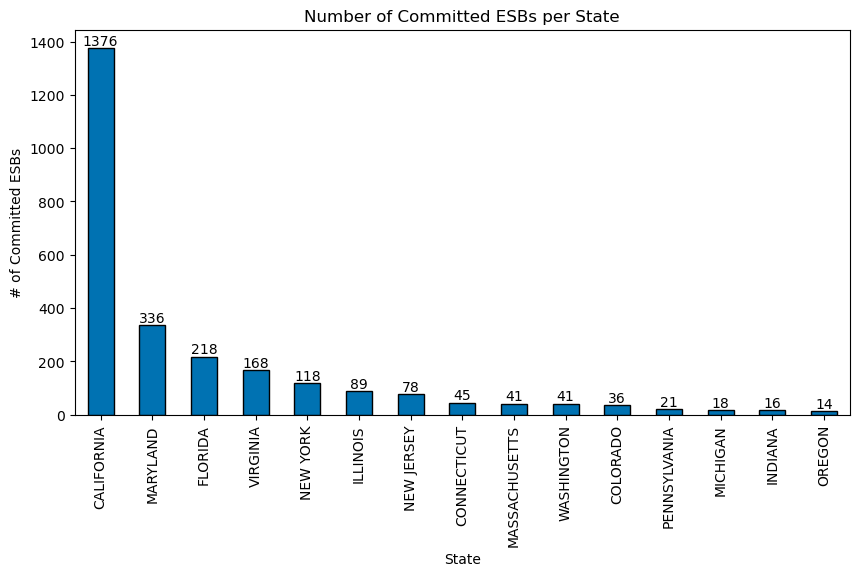

In [19]:
# Plot top 15 states by # of committed ESBs

fig = busgp_data.groupby('State').num_of_ESBs.sum().sort_values(ascending=False).head(15).plot(
    kind='bar', x = 'num_of_ESBs', edgecolor='0', figsize=(10,5))
plt.ylabel('# of Committed ESBs')
plt.title('Number of Committed ESBs per State')
fig.bar_label(fig.containers[0], label_type='edge')
plt.show()

### State Counts

At 1376, California contains more than half of all committed ESBs in the US and is the only state to have more than 1000.  Next we will look at the districts that have committed the greatest number of ESBs.  

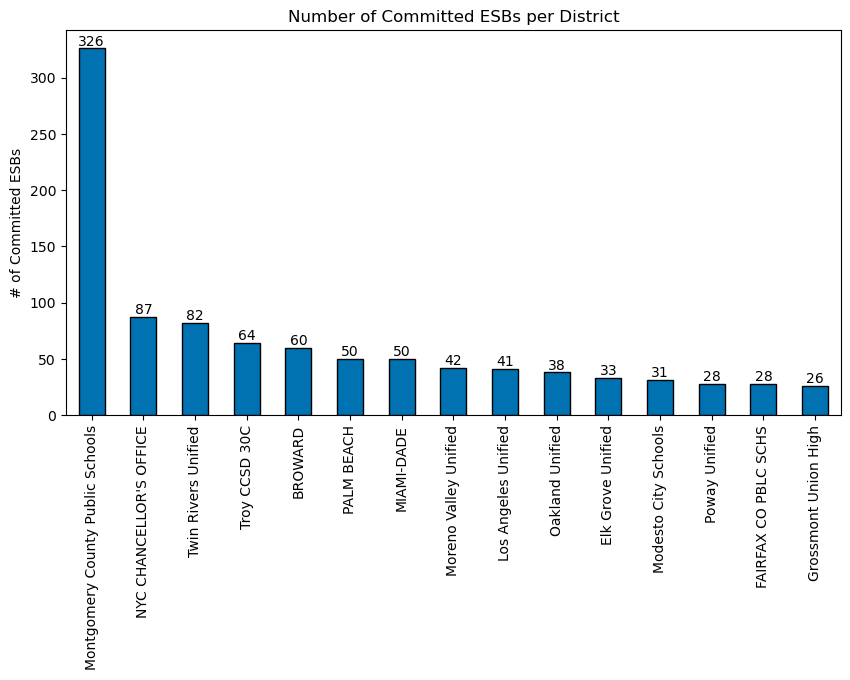

In [20]:
fig = busgp_data.groupby('LEA_name').num_of_ESBs.sum().sort_values(ascending=False).head(15).plot(
    kind='bar', x = 'num_of_ESBs', edgecolor='0', figsize=(10,5))
plt.ylabel('# of Committed ESBs')
plt.xlabel('')
plt.title('Number of Committed ESBs per District')
fig.bar_label(fig.containers[0], label_type='edge')
plt.show()

### District Counts

Montgomery County Public Schools has 4 times as many committed ESBs than any other district.  I investigated why this was the case and found that they have partnered with a company Highland and made a commitment to only have electric buses by 2035.  Hopefully more districts follow suite.  Next, let's investigate the typical number of committed ESBs that each district has. 

In [21]:
busgp_data.num_of_ESBs.describe()

count    453.000000
mean       6.000000
std       17.631679
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max      326.000000
Name: num_of_ESBs, dtype: float64

It looks like 75% of school districts have 6 or less ESBs.  Situations like Montgomery County Public Schools are currently significant outliers from the norm.  

In [22]:
# Read shape file of US states

usa = gpd.read_file('Desktop/Datasets/Maps/States/states.shp')

In [23]:
# Remove Hawaii and Alaska

usa = usa[1:50]
usa.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."
5,South Dakota,6,46,West North Central,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9..."


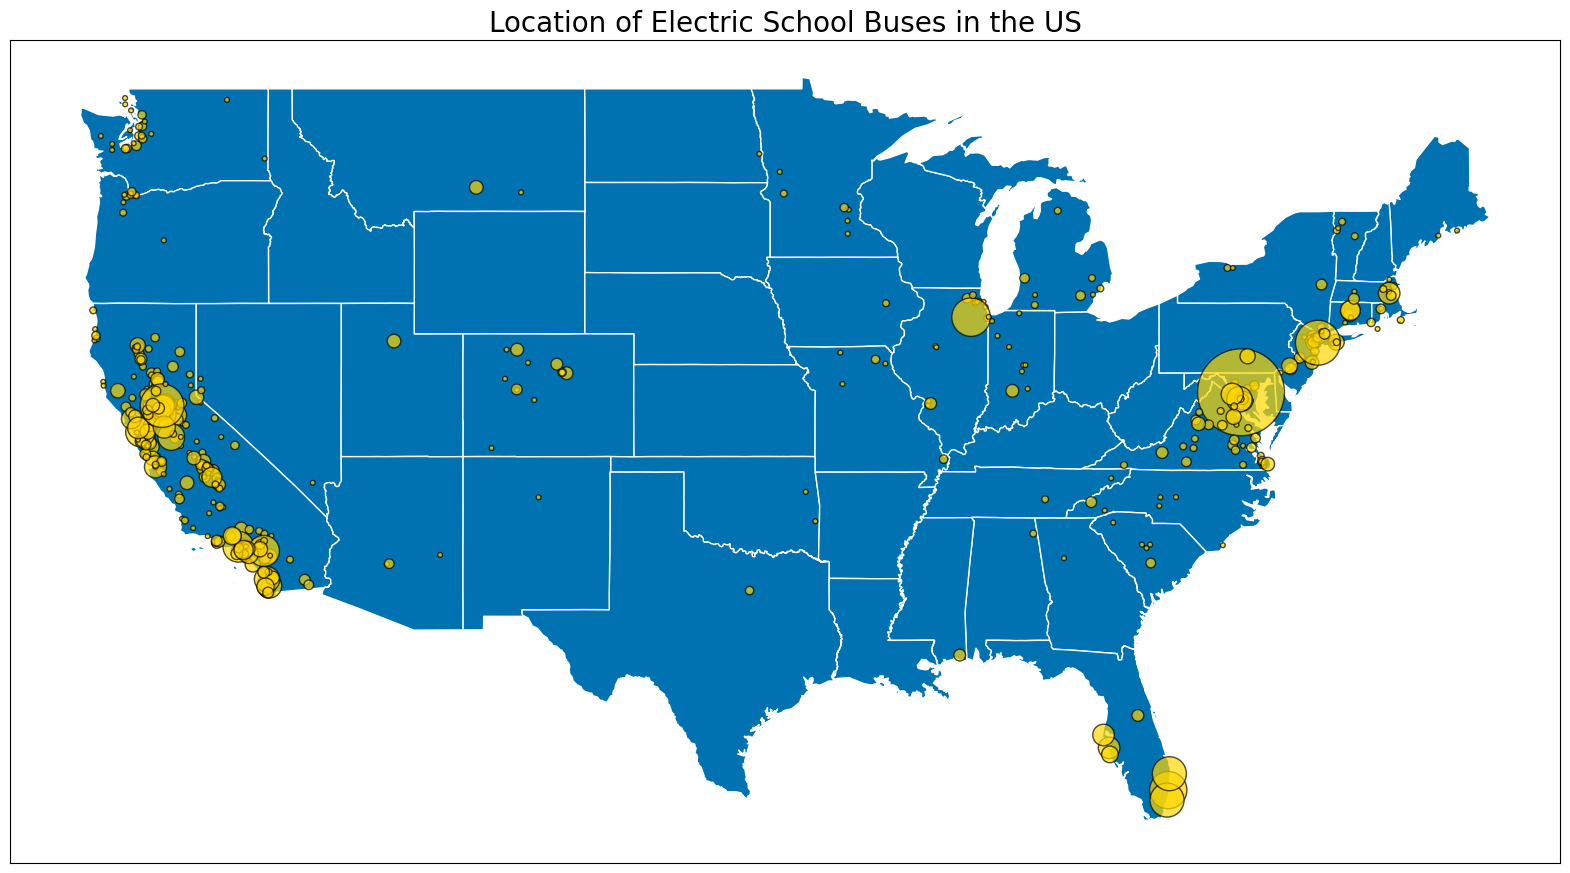

In [24]:
# Plot states with locations of ESBs

base = usa.plot(figsize=(20,20), edgecolor='white', linewidth=1)
points = busgp_data['geometry'].plot(ax=base,
                                     color='gold',
                                     marker='o',  
                                     markersize=12 * busgp_data['num_of_ESBs'], 
                                     edgecolor='black', 
                                     alpha=0.7)
plt.title('Location of Electric School Buses in the US', fontdict={'fontsize':20})
plt.tick_params(
    axis='both',         
    which='both',      
    bottom=False,     
    left=False,
    labelleft=False,
    labelbottom=False) 


### State Map

The map shows that we have a high concentration of committed ESBs on either coast of the United States.  I am curious if there is any correlation between the political leaning of each states and the number of ESBs committed.  We will use the 2020 election results to label each state as Democratic or Republican and then replot our map with the new layer.

## Political Breakdown

In [25]:
# Read presidental election data to dataframe

election_data = pd.read_csv('Desktop/Datasets/US Presidential Elections/1976-2020-president.csv')

# Isolate 2020 data

election_data = election_data[election_data.year == 2020]
election_data.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3740,2020,ALABAMA,AL,1,63,41,US PRESIDENT,"BIDEN, JOSEPH R. JR",DEMOCRAT,False,849624,2323282,20210113,NaN,DEMOCRAT
3741,2020,ALABAMA,AL,1,63,41,US PRESIDENT,"TRUMP, DONALD J.",REPUBLICAN,False,1441170,2323282,20210113,NaN,REPUBLICAN
3742,2020,ALABAMA,AL,1,63,41,US PRESIDENT,"JORGENSEN, JO",LIBERTARIAN,False,25176,2323282,20210113,NaN,LIBERTARIAN
3743,2020,ALABAMA,AL,1,63,41,US PRESIDENT,NaN,NaN,True,7312,2323282,20210113,NaN,OTHER
3744,2020,ALASKA,AK,2,94,81,US PRESIDENT,"BIDEN, JOSEPH R. JR",DEMOCRAT,False,153778,359530,20210113,NaN,DEMOCRAT


The data contains the votes for each party in each state so we need to group by state and just choose the party that has the most votes in each state.  

In [26]:
# Determine whether state voted Republican or Democratic during 2020 election

red_or_blue = election_data.loc[election_data.groupby('state')['candidatevotes'].idxmax()]
red_or_blue = red_or_blue[['state', 'state_po', 'party_simplified']]
red_or_blue.head()

,state,state_po,party_simplified
3741,ALABAMA,AL,REPUBLICAN
3745,ALASKA,AK,REPUBLICAN
3752,ARIZONA,AZ,DEMOCRAT
3771,ARKANSAS,AR,REPUBLICAN
3773,CALIFORNIA,CA,DEMOCRAT


Next, we need to join our data so we can use it within our plot of the US.

In [27]:
# Join political data with usa data

usa_colored = usa.merge(red_or_blue, left_on='STATE_ABBR', right_on='state_po', how='inner')
usa_colored.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry,state,state_po,party_simplified
0,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",WASHINGTON,WA,DEMOCRAT
1,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6...",MONTANA,MT,REPUBLICAN
2,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...",MAINE,ME,DEMOCRAT
3,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939...",NORTH DAKOTA,ND,REPUBLICAN
4,South Dakota,6,46,West North Central,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9...",SOUTH DAKOTA,SD,REPUBLICAN


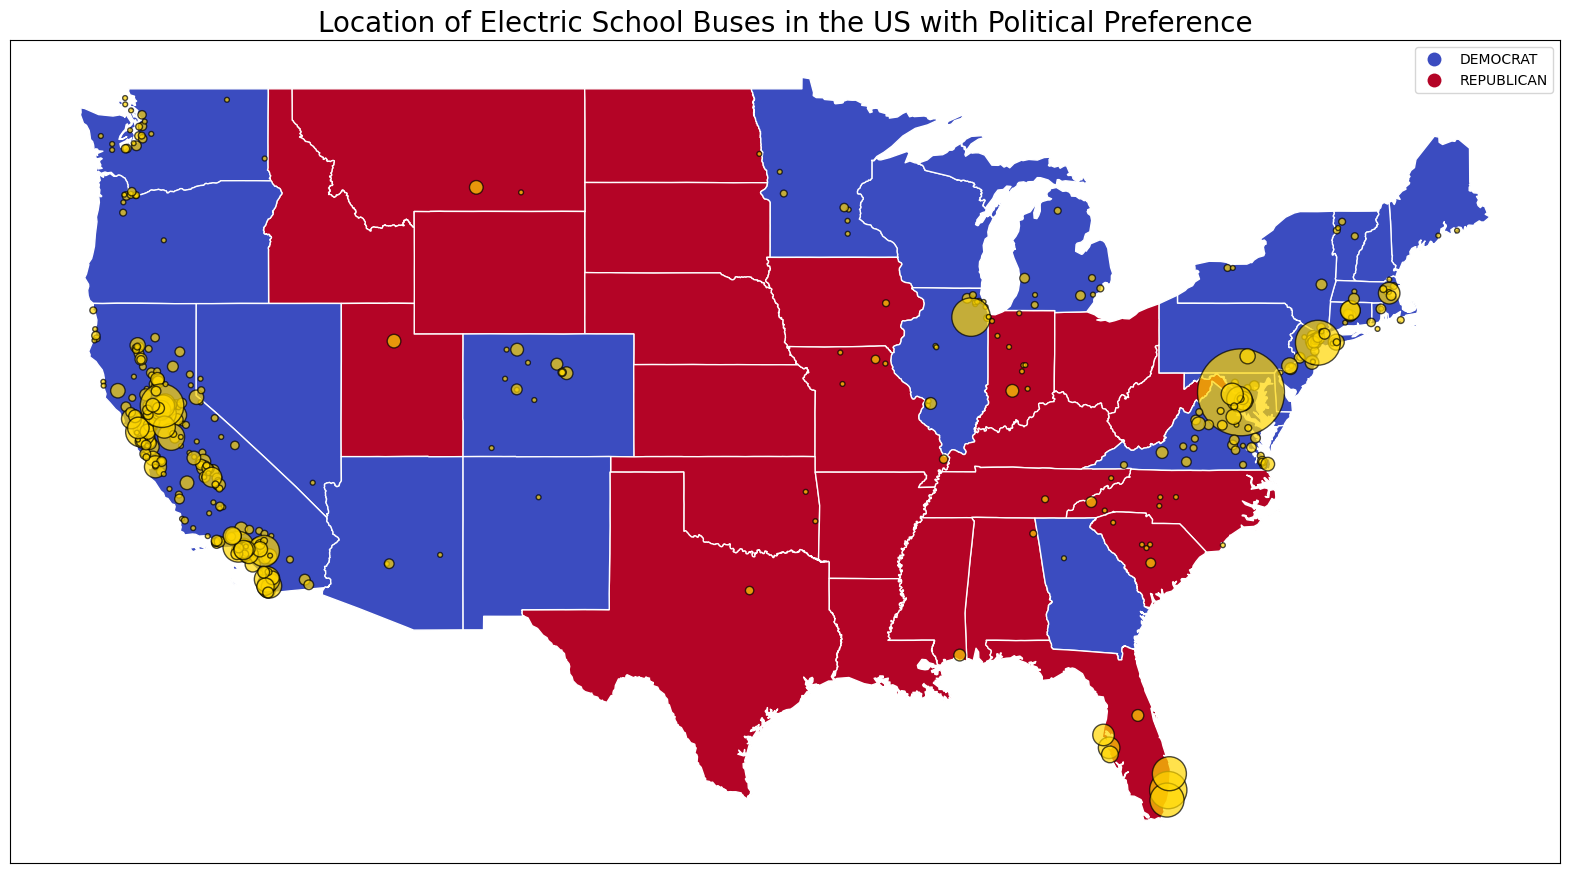

In [28]:
# Replot committed ESBs with Political leaning of each state

base = usa_colored.plot(column='party_simplified', cmap='coolwarm', legend=True,
                 figsize=(20, 20), edgecolor='white', linewidth=1)
busgp_data['geometry'].plot(ax=base, marker='o', 
                            color='gold', 
                            markersize=12 * busgp_data['num_of_ESBs'], 
                            edgecolor='black',
                            alpha=0.70)
plt.title('Location of Electric School Buses in the US with Political Preference', fontdict={'fontsize':20})
plt.tick_params(
    axis='both',         
    which='both',      
    bottom=False,     
    left=False,
    labelleft=False,
    labelbottom=False) 

### Polical Map

It looks like there is a very strong correlation between Democratic States and committed ESBs.  We will do a bar graph to get more specific values on the relationship.

In [29]:
# Join busgp_data with red_or_blue data

busgp_data = busgp_data.merge(red_or_blue, left_on='State', right_on='state', how='left')
busgp_data.head()

,Committed_ESB,State,LEA_name,LEA_id,LEA_type_num,LEA_type,Locale_type_num,Locale_type,Latitude,Longitude,num_students,num_schools,perc_title1,num_of_ESBs,geometry,state,state_po,party_simplified
0,yes,ALABAMA,Fort Payne City,101560,1.0,Regular public school district that is not a c...,3.0,Town,34.486206,-85.673755,3482.0,5.0,1.000000,2,POINT (-85.67375 34.48621),ALABAMA,AL,REPUBLICAN
1,yes,ARIZONA,Cartwright Elementary District (4282),401680,1.0,Regular public school district that is not a c...,1.0,Urban,33.496909,-112.170418,15177.0,23.0,0.952381,1,POINT (-112.17042 33.49691),ARIZONA,AZ,DEMOCRAT
2,yes,ARIZONA,Phoenix Union High School District (4286),406330,1.0,Regular public school district that is not a c...,1.0,Urban,33.502319,-112.074283,27037.0,19.0,0.894737,4,POINT (-112.07428 33.50232),ARIZONA,AZ,DEMOCRAT
3,yes,ARIZONA,Theodore Roosevelt School,5900132,1.0,Regular public school district that is not a c...,4.0,Rural,33.790127,-109.987971,100.0,1.0,1.000000,1,POINT (-109.98797 33.79013),ARIZONA,AZ,DEMOCRAT
4,yes,CALIFORNIA,Adelanto Elementary,601710,1.0,Regular public school district that is not a c...,2.0,Suburban,34.572373,-117.406551,7817.0,15.0,0.000000,2,POINT (-117.40655 34.57237),CALIFORNIA,CA,DEMOCRAT


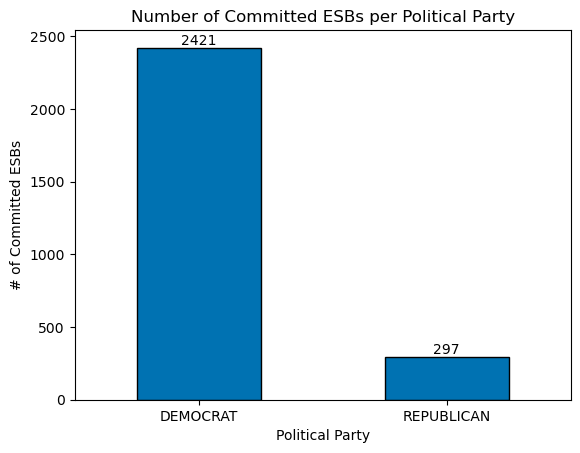

In [30]:
# Plot bar graph of committed ESBs per Political Party

fig = busgp_data.groupby('party_simplified').num_of_ESBs.sum().plot(kind='bar', rot=0, edgecolor='0')
plt.ylabel('# of Committed ESBs')
plt.xlabel('Political Party')
plt.title('Number of Committed ESBs per Political Party')
fig.bar_label(fig.containers[0], label_type='edge')
plt.show()


### Political Distribution

States that lean democrat contain 90% of committed ESBs.  I am also curious the breakdown of locale types.  My assumption is that the majority of ESBs would be in urban environments because they are historically democratic.  We will plot the number of committed ESBs per locale type.  The locale types are rural, suburban, town, and urban.

## Locale Types

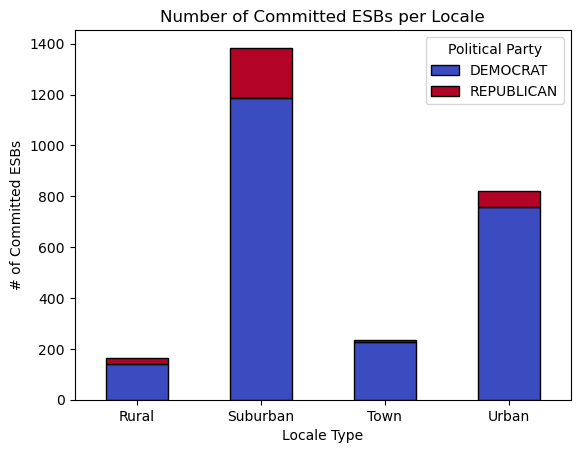

In [31]:
# Plot number of committed ESBs per locale type

fig = busgp_data.groupby(['Locale_type', 'party_simplified']).num_of_ESBs.sum().unstack().plot(
    kind='bar', rot=0, stacked=True, cmap='coolwarm', edgecolor='0')
plt.legend(title='Political Party')
plt.ylabel('# of Committed ESBs')
plt.xlabel('Locale Type')
plt.title('Number of Committed ESBs per Locale')
plt.show()

### Local Distrubtion

I was surprised to see that urban locales only included 30% of the data.  Suburban locales have the most committed ESB's.  This makes me think that wealth distribution may have an influence on what school districts are getting ESBs. We will investigate that further soon.  Next I would like to see the typical size (by number of students) of school districts that have commited ESBs.

## School District Size

In [32]:
# Check statistic on number of students column

busgp_data['num_students'].describe()

count       423.000000
mean      17760.120567
std       43729.180422
min           0.000000
25%        1962.000000
50%        5731.000000
75%       15997.500000
max      460633.000000
Name: num_students, dtype: float64

It looks like we have a some extreme outliers that are bumping up our mean so the median will be much more useful in our analysis.  The median of 5731 tells us that most schools with committed ESBs are medium to large in size.  We will make a visualization to better see the distribution of school sizes. 

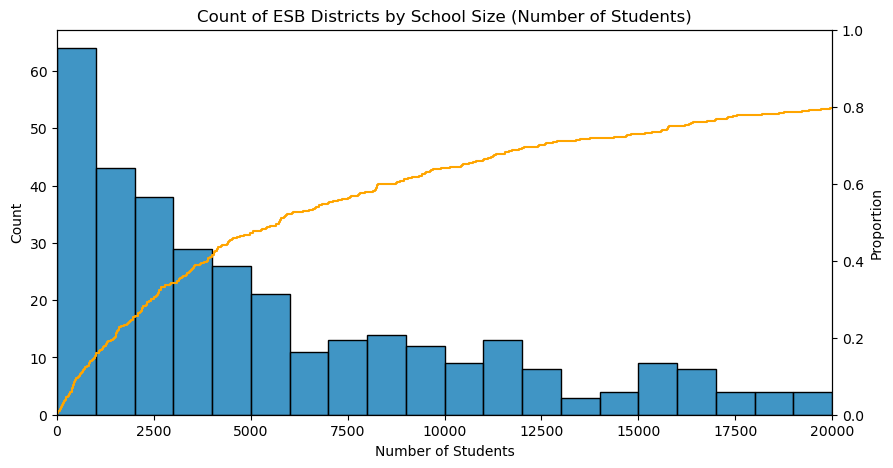

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data = busgp_data, x = 'num_students', binwidth=1000, binrange=(0, 20000), ax=ax)
plt.title('Count of ESB Districts by School Size (Number of Students)')
plt.xlabel('Number of Students')
ax.set_xlim(0, 20000)
ax2 = ax.twinx()
sns.ecdfplot(data = busgp_data, x = 'num_students', ax=ax2, color='orange')
plt.show()

## Percent Title 1

In [34]:
# Check perc_title 1 statistics

busgp_data['perc_title1'].describe()

count    427.000000
mean       0.214535
std        0.323630
min        0.000000
25%        0.000000
50%        0.000000
75%        0.404545
max        1.000000
Name: perc_title1, dtype: float64

Next we will check out the percent of Title 1 Schools in districts that have committed ESBs.  To be a Title 1 School, a school must have 40% of it's total enrollment coming from low-income families.  The data we have is the percentage of Title 1 Schools in each district that has committed ESBs.  The statistics above show us that more than 50% of all the districts with committed ESBs have no Title 1 Schools.  

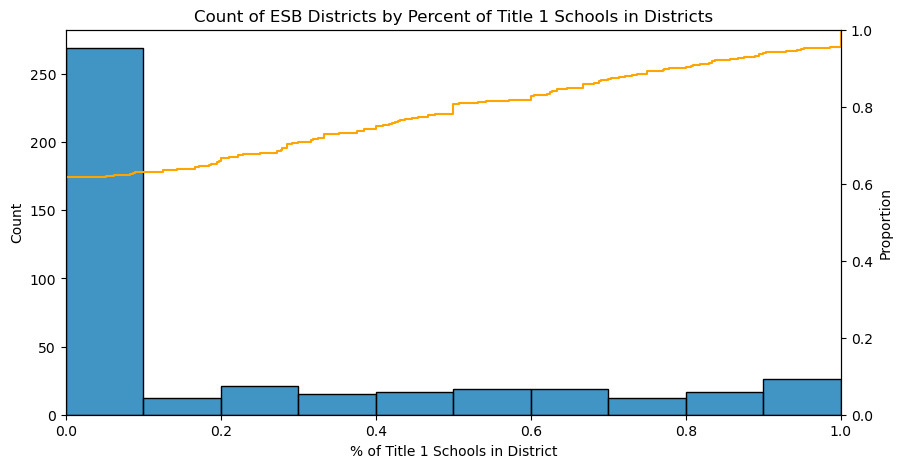

In [35]:
# Plot count of different percents of title 1 schools with bins of .1

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data = busgp_data, x = 'perc_title1', binwidth=.1, binrange=(0, 1), ax=ax)
plt.title('Count of ESB Districts by Percent of Title 1 Schools in Districts')
plt.xlabel('% of Title 1 Schools in District')
ax.set_xlim(0, 1)
ax2 = ax.twinx()
sns.ecdfplot(data = busgp_data, x = 'perc_title1', color='orange', ax=ax2)
plt.show()

### Wealth Distribution

This confirms that the large majority of schools that have committed ESBs are wealthier (have none or very low percentage of title 1 schools).  

## Conclusion

Electric school buses are very rare.  There are currently less than 3000 committed ESBs in the US.  Hopefully this number increases in the years to come as I can personally attest to the enormous amount of miles that school buses drive each year.  The following findings were ones that I was not surprised by:

- Democratic leaning states account for 90% of all electric school buses.
- ESBs were primarily located on the West and East Coast
- Wealthier districts are much more likely to have committed ESBs

Discoveries that didn't align with my original expectations included:

- Medium sized districts were the most likely to have committed ESBs
- Suburban locales were the most likely to have committed ESBs

I expected very large districts with enormous funding and very small wealthy districts to be the main users of electric buses.  I also expected urban districts to be the most likely to have committed ESBs but they only account for about 30%. 

